# BY- JAYENT SINGH PARIHAR

## Project- Data Science Salaries 2023 💸

## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import Statistics libraries
from scipy import stats
from scipy.stats import norm

# Import Scikit-learn for Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

# Import country code libraries
!pip install pycountry -q
import pycountry

#Install plot library
import plotly.io as pio
pio.renderers.default='notebook'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.2 MB/s eta 0:00:00


## Input data

In [2]:
data = pd.read_csv('/content/ds_salaries.csv')

## EXPLORATORY DATA ANALYSIS

### Data Quality

### Check null and Missing Values

In [3]:
#check missing ratio
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

Empty DataFrame
Columns: [Missing Ratio]
Index: []

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Ratio']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Ratio'}, axis=1)
              .sort_values('Missing Ratio', ascending=True))
  xs = counted['Missing Ratio']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('Missing Ratio', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Ratio')
_ = plt.ylabel('count()')

### Check Duplicates

In [4]:
# Handle duplicates
duplicate_rows_data = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (1171, 11)


### Check Unique Value in each columns

In [5]:
# Loop through each column and count the number of distinct values
for column in data.columns:
    num_distinct_values = len(data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

work_year: 4 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 93 distinct values
salary: 815 distinct values
salary_currency: 20 distinct values
salary_in_usd: 1035 distinct values
employee_residence: 78 distinct values
remote_ratio: 3 distinct values
company_location: 72 distinct values
company_size: 3 distinct values


### Explore the data

In [6]:
data.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

### Rename the value for better understanding

In [7]:
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

### Group the job title

In [8]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

## Dealing with Inflation rate

### Adjusted the income to Present Value

In [9]:
# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Apply the function to the dataset
data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

## Univariative Analysis

### Job Distribution

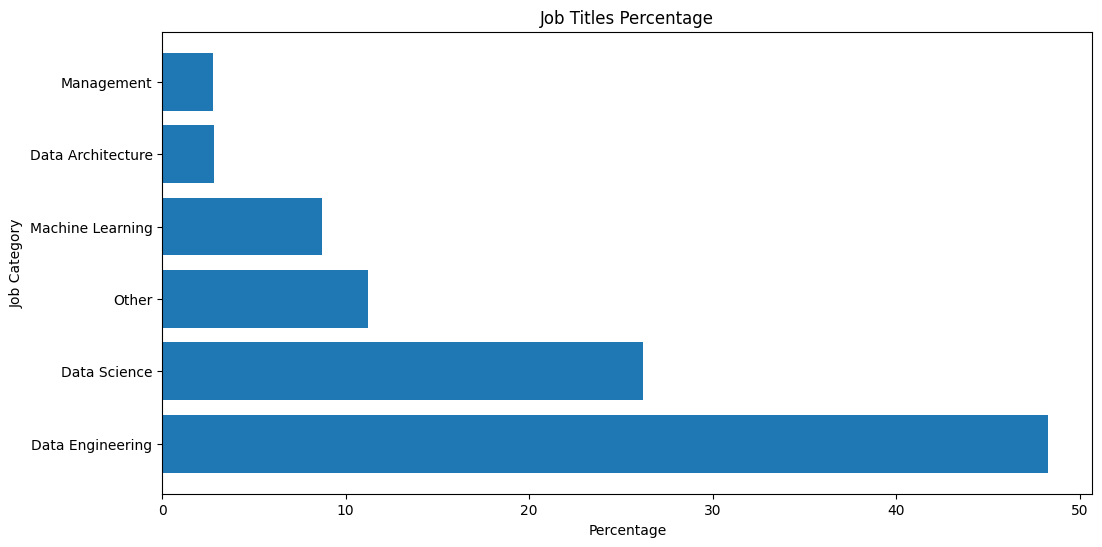

In [10]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

### Distribution across different employment types

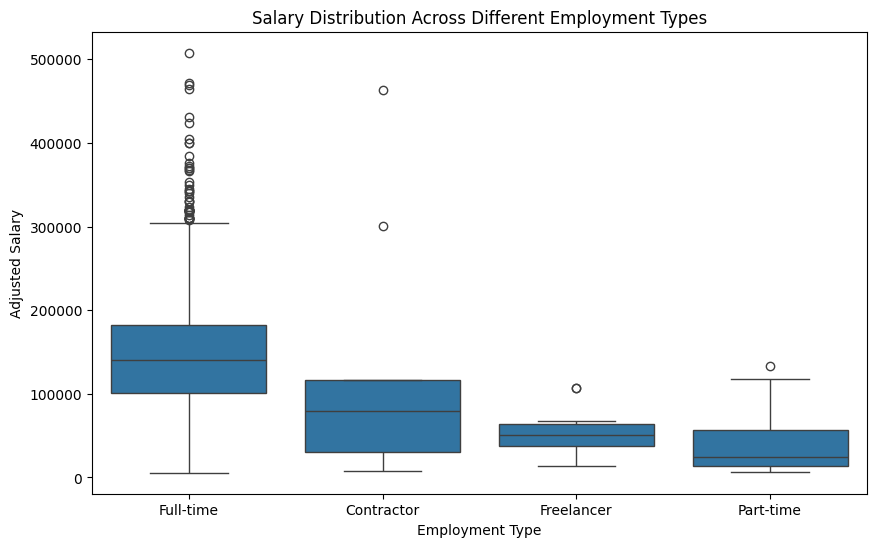

In [11]:
# Salary distribution across different employment types
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='employment_type', y='adjusted_salary')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary')
plt.show()

### Distribution of Salary

adjusted_salary: mu = 142445.66, sigma = 64692.98
adjusted_salary: Skewness: 0.58
adjusted_salary: Kurtosis: 1.14


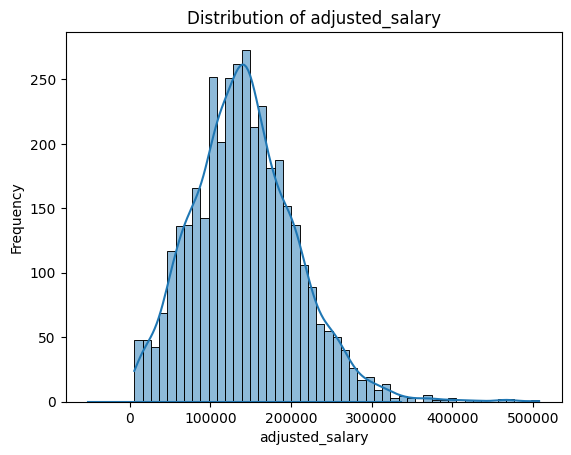

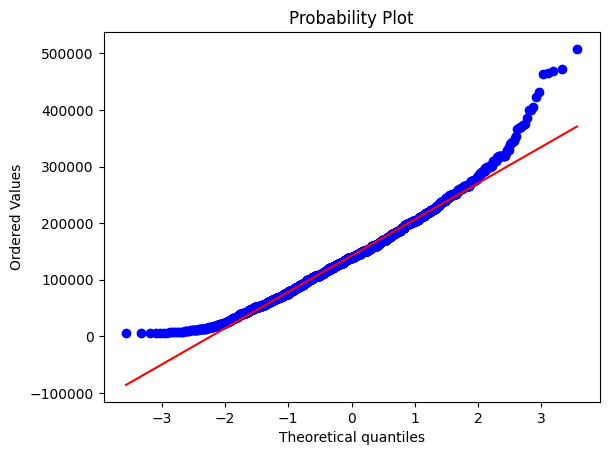

In [12]:
# Create a list of the columns to analyze
columns = ['adjusted_salary']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(data[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, data[col].kurt()))

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(data[col], plot=plt)

    plt.show()


### Boxplot and Swarmplot of Adjusted Salary

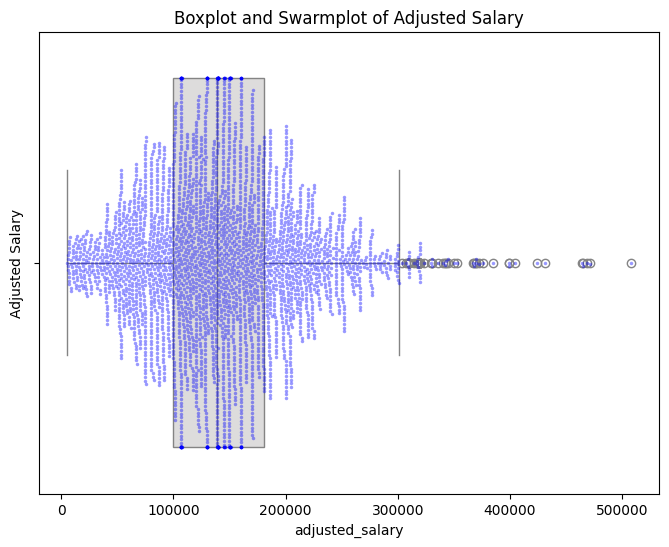

In [13]:
# apply formatting to describe method for 'adjusted_salary' column
formatted_data = data.loc[:, 'adjusted_salary'].describe().apply(lambda x: f'{x:.2f}')

# create boxplot and swarmplot for 'adjusted_salary' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['adjusted_salary'], palette='coolwarm')
sns.swarmplot(x=data['adjusted_salary'], color='blue', alpha=0.4, size=2.5)
plt.ylabel('Adjusted Salary')
plt.title('Boxplot and Swarmplot of Adjusted Salary')
plt.show()

# apply styling to formatted data
styled_data = formatted_data.to_frame().style \
    .background_gradient(cmap='Blues') \
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# display styled data
display(styled_data)

## Bivariative Analysis

### Median salary by job title¶

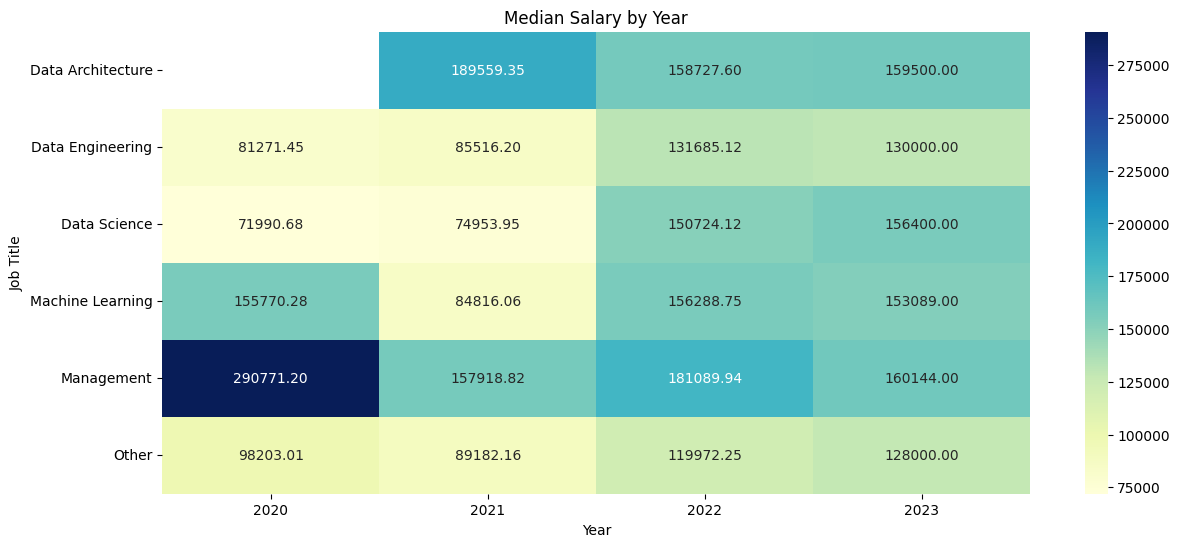

In [14]:
df = data.copy()

#  Median salary by job title
pivot_table = df.pivot_table(values='adjusted_salary', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

## Multivariative Analysis

### Salary comparison between employee residence and company location

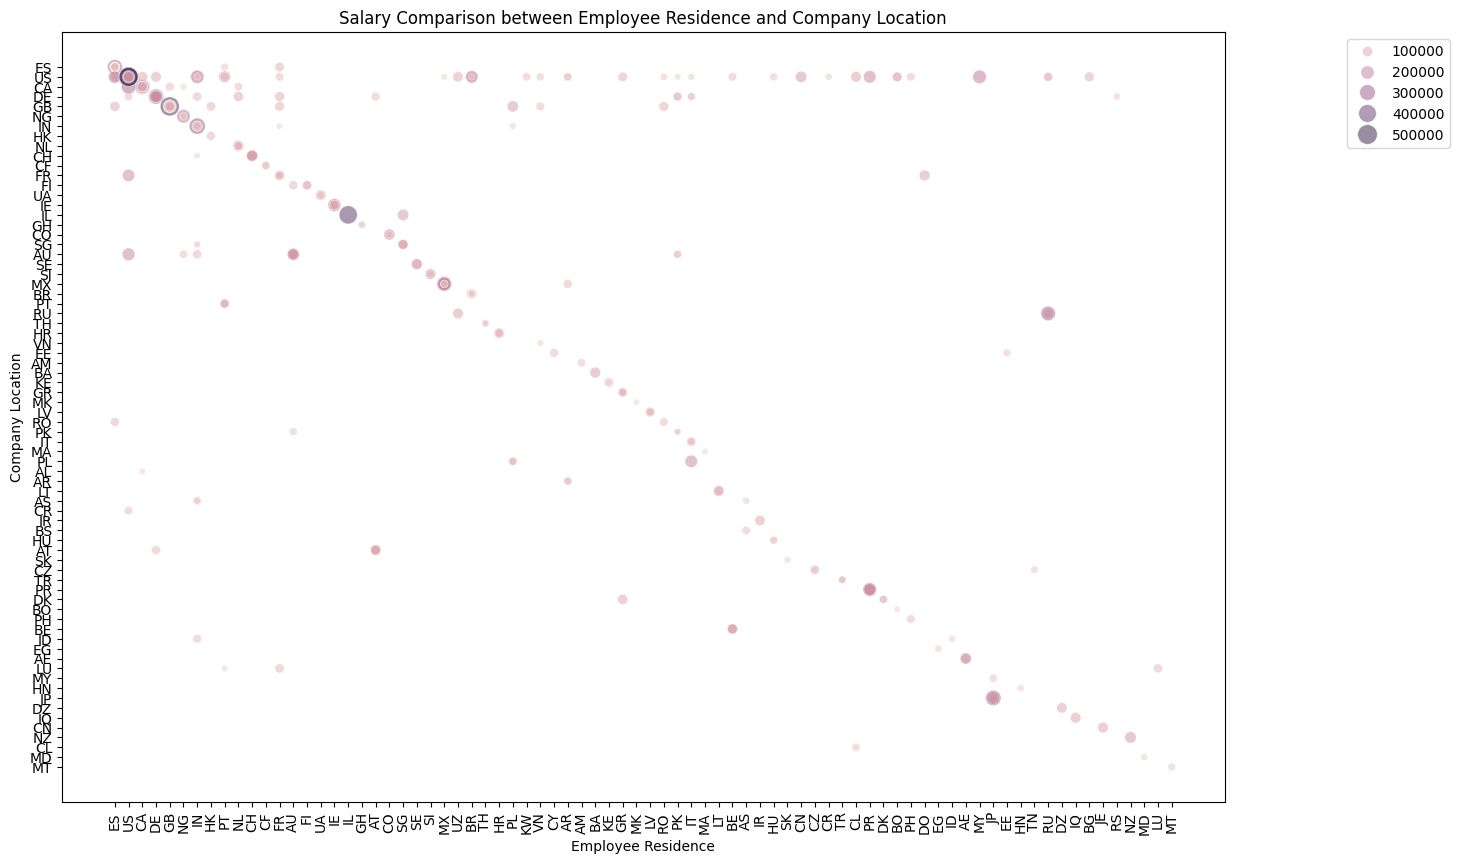

In [15]:
# Salary comparison between employee residence and company location
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='employee_residence', y='company_location', hue='adjusted_salary', size='adjusted_salary', sizes=(20, 200), alpha=0.5)
plt.title('Salary Comparison between Employee Residence and Company Location')
plt.xlabel('Employee Residence')
plt.ylabel('Company Location')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

## GEOSPATIAL ANALYSIS

### Convert the country code to the country name

In [16]:
# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return country_code
    # Function to convert country code to full name
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except:
        return None

### Average salary by location of the organization

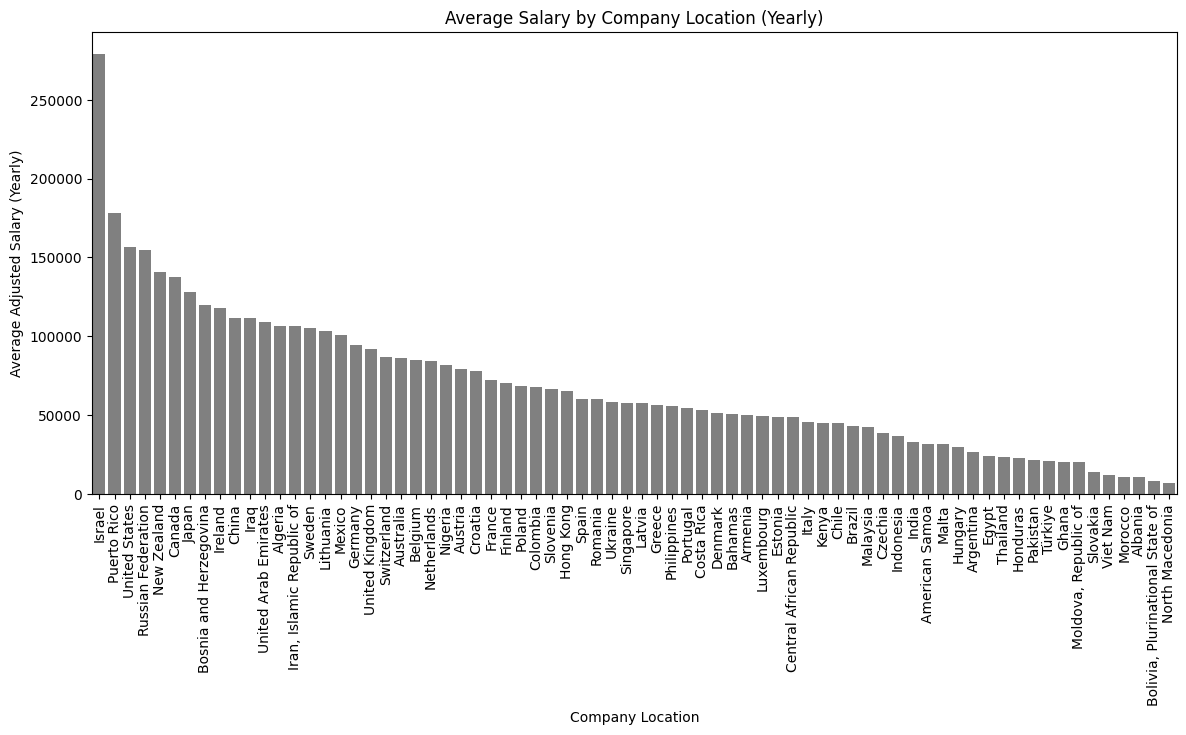

In [17]:
# Convert country codes to names
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

# Average salary by company_location
avg_salary_by_location = df.groupby('company_location', as_index=False)['adjusted_salary'].mean()

fig1 = px.choropleth(avg_salary_by_location,
                     locations='company_location',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='company_location',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Company Location',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')


fig1.show()

# Average salary by company_location
avg_salary_by_location = df.groupby('company_location')['adjusted_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_location.index, y=avg_salary_by_location, color='grey')
plt.title('Average Salary by Company Location (Yearly)')
plt.xlabel('Company Location')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()

### Which country generate the highest wages

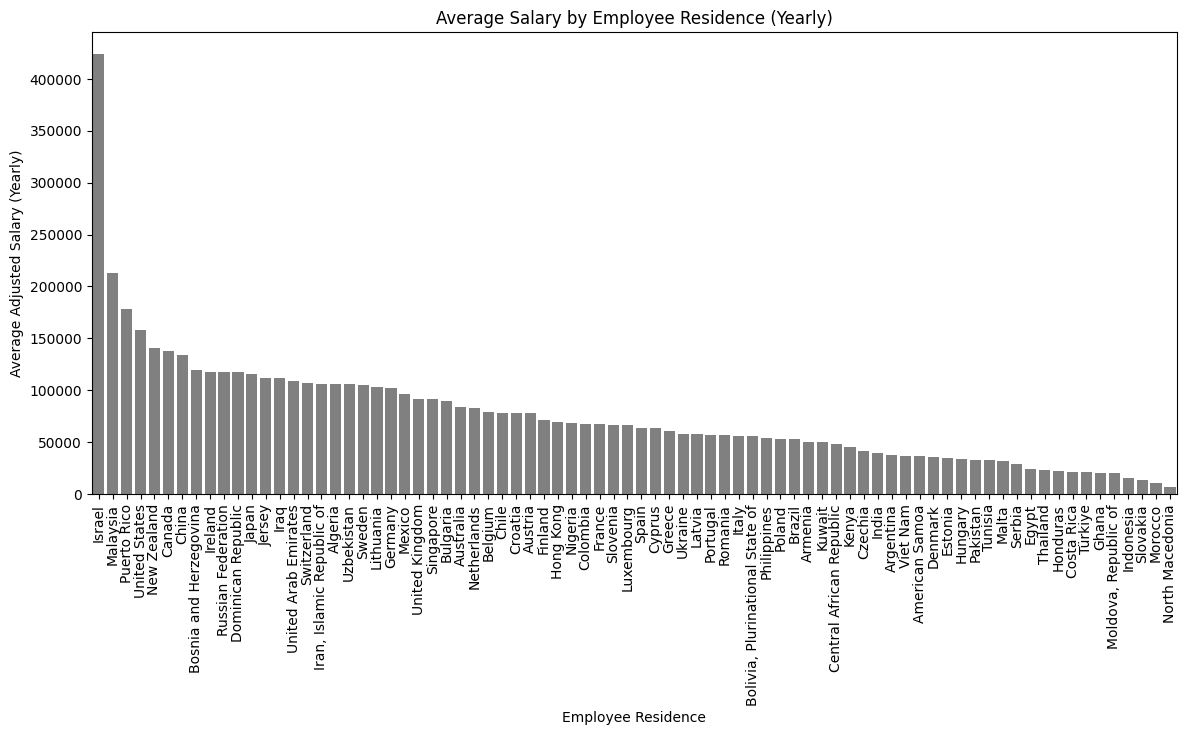

In [18]:
# Average salary by employee_residence
avg_salary_by_residence = df.groupby('employee_residence', as_index=False)['adjusted_salary'].mean()

fig2 = px.choropleth(avg_salary_by_residence,
                     locations='employee_residence',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='employee_residence',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.show()

# Average salary by employee_residence
avg_salary_by_residence = df.groupby('employee_residence')['adjusted_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_residence.index, y=avg_salary_by_residence.values, color='grey')
plt.title('Average Salary by Employee Residence (Yearly)')
plt.xlabel('Employee Residence')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()

### Which country doesn't demand that you work on the job

In [19]:
# Filter for remote_ratio of 100
remote_100 = data[data['remote_ratio'] == 'Full-Remote']

# Aggregate by country code
country_counts = remote_100['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)

# Create the choropleth map with a logarithmic color scale
fig = px.choropleth(country_counts,
                    locations='country_name',
                    locationmode='country names',
                    color=np.log10(country_counts['count']),
                    hover_name='country_name',
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Choropleth Map of Full-Remote Company Locations',
                    projection='natural earth')


# Customize the colorbar to show the original count values
fig.update_coloraxes(colorbar=dict(title='Count (Log Scale)', tickvals=[0, 1, 2, 3], ticktext=['1', '10', '100', '1000']))

# Show the map
fig.show()

### Where is the business situated?

In [20]:
# Filter for remote_ratio of 100
remote_0 = data[data['remote_ratio'] == 'On-Site']

# Aggregate by country code
country_counts = remote_0['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)

# Create the choropleth map with a logarithmic color scale
fig = px.choropleth(country_counts,
                    locations='country_name',
                    locationmode='country names',
                    color=np.log10(country_counts['count']),
                    hover_name='country_name',
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Choropleth Map of On-Site Company Locations',
                    projection='natural earth')

# Customize the colorbar to show the original count values
fig.update_coloraxes(colorbar=dict(title='Count (company)', tickvals=[0, 1, 2, 3], ticktext=['1', '10', '100', '1000']))

# Show the map
fig.show()

## CORRELATION

### Dealing with categorical and numerical column

### Select Columns

In [21]:
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category']
numerical_columns = ['adjusted_salary']

### Dealing with categorical variables

### Create Dummy Variables

In [22]:
dummy_variables = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

### Preprocessing : Standard Scaler

### Preprocessing and Scaling the data

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(df[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

In [24]:
# Drop the original numerical columns
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenate the dummy variables and scaled numerical columns
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df = processed_df.drop(['work_year', 'salary','salary_in_usd'], axis=1)

### Corelation Matrix with dummy variables

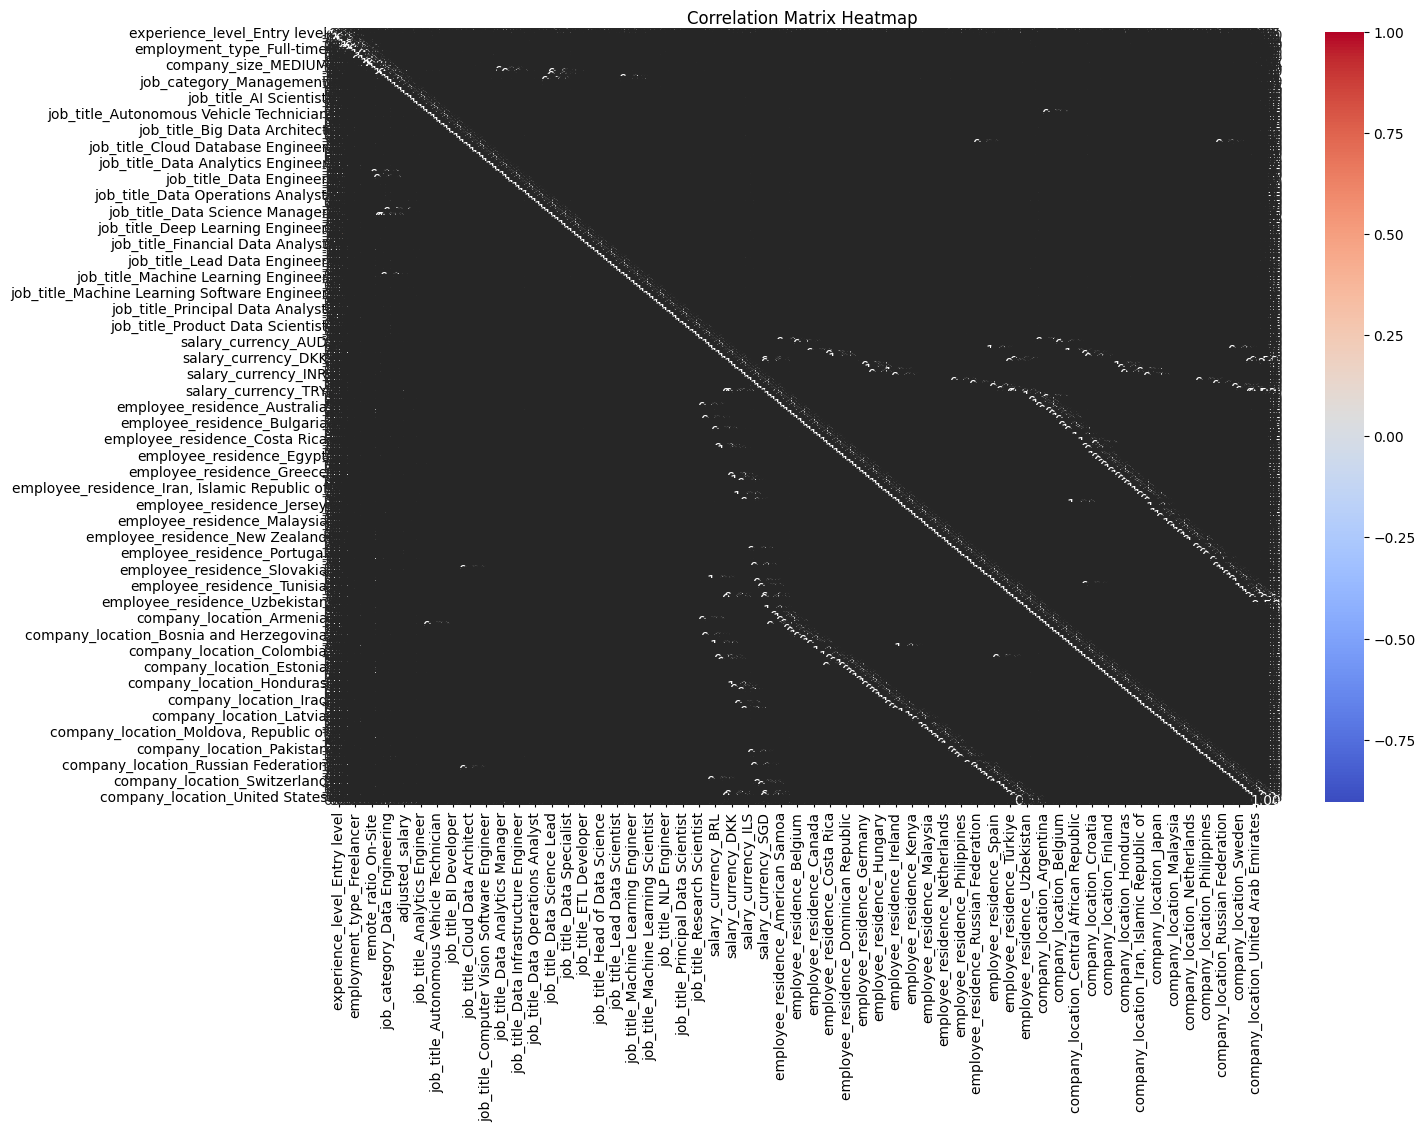

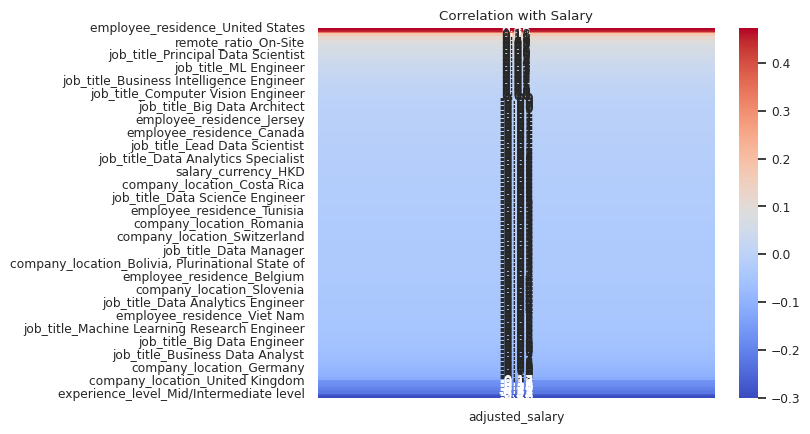

In [25]:
# Convert 'object' columns to numerical using one-hot encoding
for col in processed_df.select_dtypes(include=['object']):
    processed_df = pd.get_dummies(processed_df, columns=[col], prefix=col)

correlation_matrix = processed_df.corr()

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = processed_df.corr()
target_corr = corr['adjusted_salary'].drop('adjusted_salary')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

#Graph II
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

## PREDICTIVE ANALYSIS

### Important Features

### Data preparation

In [26]:
# create dictionary of country code to country name mappings
country_map = {}
for country in pycountry.countries:
    country_map[country.alpha_2] = country.name
# replace values in 'employee_residence' column using dictionary
data['employee_residence'] = data['employee_residence'].replace(country_map)
data['company_location'] = data['company_location'].replace(country_map)

In [27]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','salary_in_usd','salary_in_usd','job_title'], axis=1)

In [28]:
df.head()

experience_level employment_type employee_residence remote_ratio  \
0                  Senior       Full-time              Spain  Full-Remote   
1  Mid/Intermediate level      Contractor      United States  Full-Remote   
2  Mid/Intermediate level      Contractor      United States  Full-Remote   
3                  Senior       Full-time             Canada  Full-Remote   
4                  Senior       Full-time             Canada  Full-Remote   

  company_location company_size      job_category  adjusted_salary  
0            Spain        LARGE             Other          85847.0  
1    United States        SMALL  Machine Learning          30000.0  
2    United States        SMALL  Machine Learning          25500.0  
3           Canada       MEDIUM      Data Science         175000.0  
4           Canada       MEDIUM      Data Science         120000.0

## Clustering Analysis

### Preprocessing

In [29]:
# Create a copy of the dataframe to not alter the original
df_preprocessed = df.copy()

# Preprocessing: Label encoding for categorical variables
le = LabelEncoder()
categorical_features = ['experience_level', 'employment_type', 'job_category', 'employee_residence', 'company_location', 'company_size', 'remote_ratio']
for feature in categorical_features:
    df_preprocessed[feature] = le.fit_transform(df[feature])

# Preprocessing: MinMax scaling for numerical/ratio variables
mm = MinMaxScaler()
numerical_features = ['adjusted_salary']
for feature in numerical_features:
    df_preprocessed[feature] = mm.fit_transform(df[feature].values.reshape(-1,1))

### T-SNE Clustering

In [30]:
# Apply t-SNE with different perplexity and learning rate
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(df_preprocessed)

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['adjusted_salary'] = df['adjusted_salary']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='adjusted_salary', title='t-SNE plot colored by Salary')
fig.show()

## Salary Prediction

### Remove Outliers with IQR method

In [31]:
# Outlier detection using IQR method
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Apply outlier detection to numeric columns only
df[numeric_df.columns] = numeric_df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

### Categorize salary to seven ranges

In [32]:
# Calculate quantiles for salary bin edges
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df['salary_range'] = pd.cut(df['adjusted_salary'], bins=bin_edges, labels=salary_labels, include_lowest=True)

### Preprocessing

In [33]:
# Label encoding for categorical features
encoder = LabelEncoder()
categorical_features = ['employment_type', 'job_category', 'experience_level',
                        'employee_residence', 'remote_ratio', 'company_location', 'company_size']
for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature])
# Split the dataset into training and testing sets
X = df.drop(["adjusted_salary", "salary_range"], axis=1)
y = df["salary_range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Traning and Validation

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load your dataset
# Assuming your dataset is a DataFrame called df with features X and target y
# df = pd.read_csv('your_dataset.csv')
# X = df.drop(columns=['target'])
# y = df['target']

# For demonstration purposes, let's create a sample dataset with NaNs
np.random.seed(0)
X = pd.DataFrame(np.random.randn(100, 5))
y = np.random.randint(0, 2, 100)
X.iloc[::10, 0] = np.nan  # introduce NaN values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Model training, evaluation, and selection
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    # Correctly ordered SimpleImputer and StandardScaler in the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}")

    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")


Model performance:
Logistic Regression - Accuracy: 0.50
Random Forest - Accuracy: 0.55
Gradient Boosting - Accuracy: 0.55
Best model: RandomForestClassifier() with accuracy: 0.55


## Confusion Matrix

Model performance:
Logistic Regression - Accuracy: 0.50
Random Forest - Accuracy: 0.55
Gradient Boosting - Accuracy: 0.55
Best model: RandomForestClassifier() with accuracy: 0.55


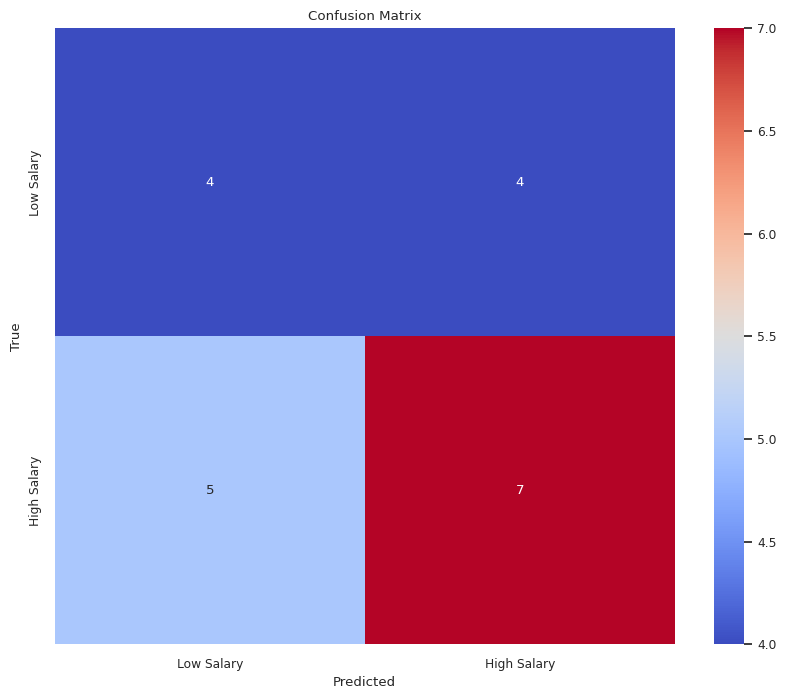

Classification Report:
              precision    recall  f1-score   support

  Low Salary       0.44      0.50      0.47         8
 High Salary       0.64      0.58      0.61        12

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.56      0.55      0.55        20



In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Create a sample dataset with NaNs
np.random.seed(0)
X = pd.DataFrame(np.random.randn(100, 5))
y = np.random.randint(0, 2, 100)
X.iloc[::10, 0] = np.nan  # introduce NaN values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Model training, evaluation, and selection
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    # Correctly ordered SimpleImputer and StandardScaler in the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}")

    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")

# Define the labels for the confusion matrix
salary_labels = ['Low Salary', 'High Salary']

# Generate the confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=salary_labels))


## EXTRA | Who makes the most money

In [41]:
# Visualize the adjusted_salary by different categories
cat_columns = ['employment_type', 'job_category', 'experience_level', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

# Determine the best categories for maximizing salary
def get_best_categories(df, cat_columns):
    best_categories = {}
    for col in cat_columns:
        best_category = df.groupby(col)['adjusted_salary'].mean().idxmax()
        best_categories[col] = best_category
    return best_categories

best_categories = get_best_categories(df, cat_columns)
print("Best categories for maximizing adjusted salary:")
for key, value in best_categories.items():
    print(f"{key.capitalize()}: {value}")

Best categories for maximizing adjusted salary:
Employment_type: 2
Job_category: 4
Experience_level: 1
Employee_residence: 46
Remote_ratio: 2
Company_location: 56
Company_size: 1
